In [14]:
import pandas as pd
import numpy as np
from pygam import LinearGAM, s, f
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from functools import reduce

In [15]:
# Load data
df = pd.read_csv(r"../Patrick/race_predictor_data.csv")

features = ['averageCumRacerPoints', 'qualifyingALPC', 'averageDriverExpYears', 'avgDriverRaceCount', 'FRALPC',
            'absolute_position_diff', 'absGridDelta']

categorical_features = ['circuitId', 'countryId', 'topTenDiversity']

for feature in categorical_features:
    df[feature + '_code'] = pd.Categorical(df[feature]).codes

all_features = features + [feature + '_code' for feature in categorical_features]

target = 'totalDNFs'
alpc_target = 'ALPC'

df = df.dropna(subset=all_features + [target] + [alpc_target])

X = df[features].values
y = df[target].values
alpc_y = df[alpc_target].values

In [16]:
# Split into train and test sets (e.g., 80/20 split)
X_train, X_test, y_train, y_test, alpc_y_train, alpc_y_test = train_test_split(
    X, y, alpc_y,
    test_size=0.2, 
    random_state=777
)

# Scale features using training data stats
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
# 10-fold CV on training set to estimate performance
kf = KFold(n_splits=10, 
           shuffle=True, 
           random_state=777)

In [18]:
mse_scores = []
r2_scores = []
categorical_indices = []

for feature in categorical_features:
    categorical_indices.append(all_features.index(feature + '_code'))

for train_idx, val_idx in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    terms = reduce(lambda a, b: a + b, [f(i) if i in categorical_indices else s(i) for i in range(X_tr.shape[1])])
    gam = LinearGAM(terms).fit(X_tr, y_tr)
    y_val_pred = gam.predict(X_val)

    mse_scores.append(mean_squared_error(y_val, y_val_pred))
    r2_scores.append(r2_score(y_val, y_val_pred))

print(f"Training CV Average MSE: {np.mean(mse_scores):.4f}")
print(f"Training CV Average R²: {np.mean(r2_scores):.4f}")

Training CV Average MSE: 4.5814
Training CV Average R²: 0.7391


In [19]:
# Train final model on full training data
terms = reduce(lambda a, b: a + b, [f(i) if i in categorical_indices else s(i) for i in range(X_tr.shape[1])])
dnf_gam = LinearGAM(terms).fit(X_train_scaled, y_train)

In [20]:
# Evaluate on test set
y_test_pred = dnf_gam.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test Set MSE: {test_mse:.4f}")
print(f"Test Set R²: {test_r2:.4f}")

Test Set MSE: 6.4923
Test Set R²: 0.6029


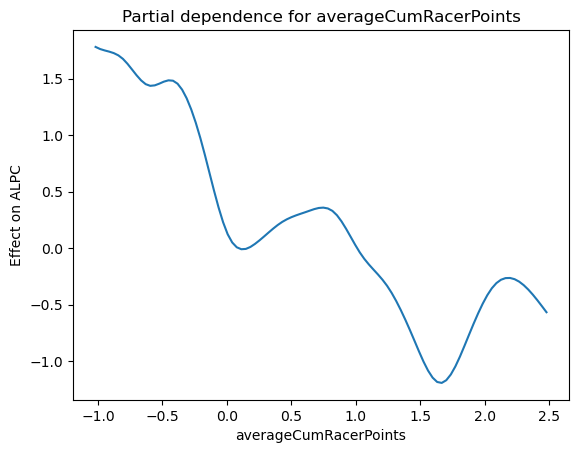

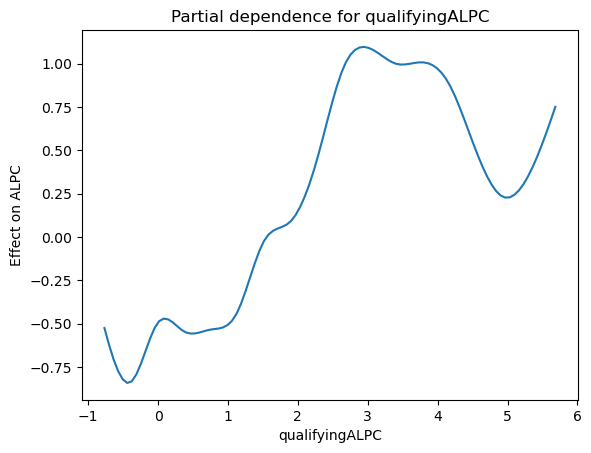

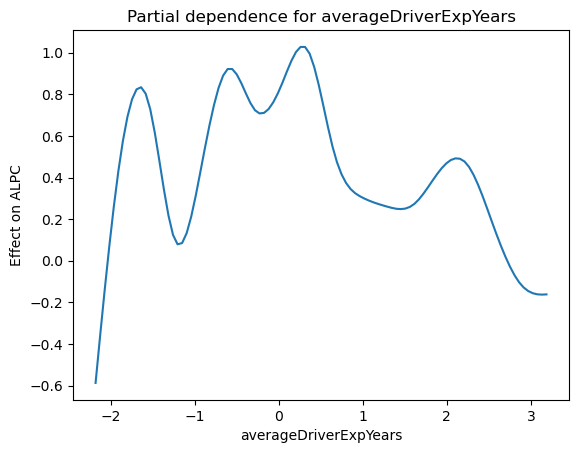

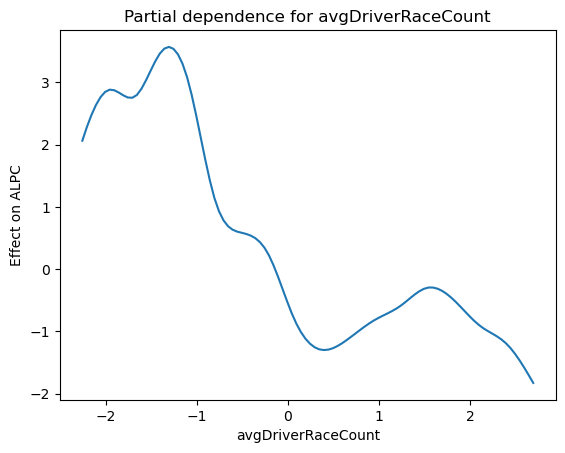

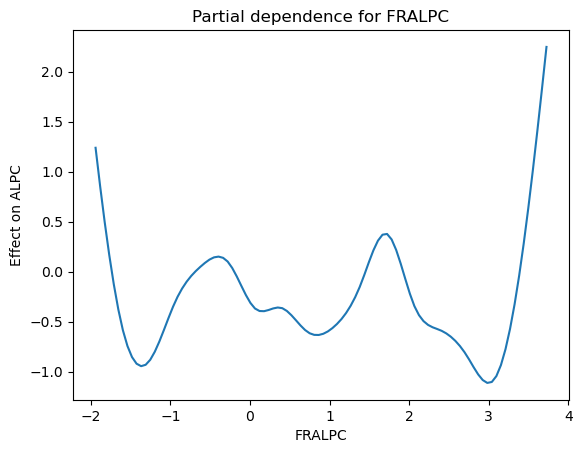

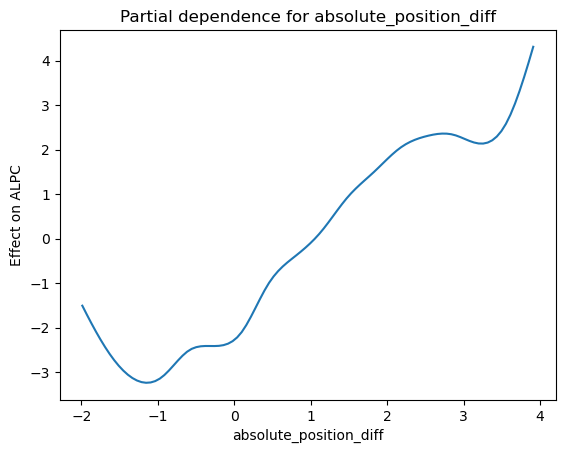

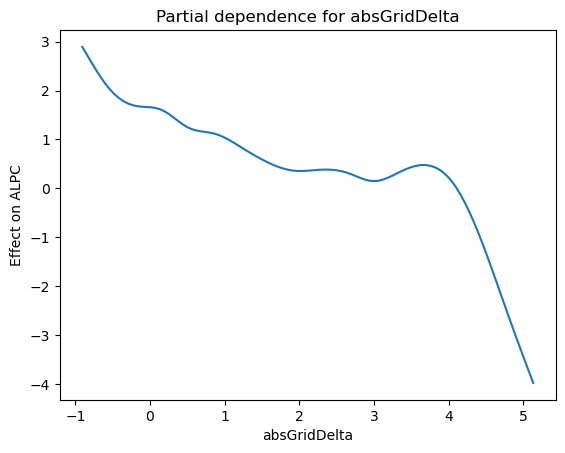

In [21]:

# Optional: Plot partial dependence on full training data
for i, feature in enumerate(features):
    XX = dnf_gam.generate_X_grid(term=i)
    plt.figure()
    plt.title(f'Partial dependence for {feature}')
    plt.plot(XX[:, i], dnf_gam.partial_dependence(term=i, X=XX))
    plt.xlabel(feature)
    plt.ylabel('Effect on ALPC')
    plt.show()


In [22]:
predicted_dnf_train = dnf_gam.predict(X_train_scaled)
predicted_dnf_test = dnf_gam.predict(X_test_scaled)

In [23]:
new_X_train = np.column_stack([X_train_scaled, predicted_dnf_train])
new_X_test = np.column_stack([X_test_scaled, predicted_dnf_test])

In [24]:
alpc_mse_scores = []
alpc_r2_scores = []

for train_idx, val_idx in kf.split(new_X_train):
    X_tr, X_val = new_X_train[train_idx], new_X_train[val_idx]
    y_tr, y_val = alpc_y_train[train_idx], alpc_y_train[val_idx]

    terms = reduce(lambda a, b: a + b, [s(i) for i in range(X_tr.shape[1])])
    gam = LinearGAM(terms).fit(X_tr, y_tr)
    y_val_pred = gam.predict(X_val)

    alpc_mse_scores.append(mean_squared_error(y_val, y_val_pred))
    alpc_r2_scores.append(r2_score(y_val, y_val_pred))

print(f"Training CV Average MSE: {np.mean(alpc_mse_scores):.4f}")
print(f"Training CV Average R²: {np.mean(alpc_r2_scores):.4f}")

Training CV Average MSE: 0.5209
Training CV Average R²: 0.3842


In [25]:
alpc_terms = reduce(lambda a, b: a + b, [s(i) for i in range(new_X_train.shape[1])])
alpc_gam = LinearGAM(alpc_terms).fit(new_X_train, alpc_y_train)

In [26]:
alpc_pred = alpc_gam.predict(new_X_test)

print("ALPC Test MSE:", mean_squared_error(alpc_y_test, alpc_pred))
print("ALPC Test R²:", r2_score(alpc_y_test, alpc_pred))

ALPC Test MSE: 0.5112557610837847
ALPC Test R²: 0.44403362171519245
